In [1]:
import numpy as np



In [2]:
import sys
import numpy as np
from lmfit import Model
from lmfit.models import GaussianModel, SkewedGaussianModel, LorentzianModel, VoigtModel
import warnings
warnings.filterwarnings("ignore")

class Image:    
    def __init__(self, image):
        self.raw = image
        self.shape= image.shape
        self.x_size= image.shape[1]
        self.y_size= image.shape[0]
        self.subtracted_data= np.array([[0 for x in range(self.x_size)] for y in range(self.y_size)])
        self.profile_x= [0 in range (self.x_size)]
        self.profile_y= [0 in range (self.y_size)]
        self.offset_x= 0 
        self.offset_y= 0
      
    def subtract_bg(self,bg):
        print("Subtracting background...")
        if (bg.shape == self.shape): 
            for i in range(self.y_size):
                for j in range (self.x_size):
                    if ((self.raw[i][j]>bg[i][j]).all() and (bg[i][j]>=0).all() and (self.raw[i][j]>=0).all()):
                        self.subtracted_data[i][j]= self.raw[i][j]-bg[i][j]
                    elif (bg[i][j]<0):
                        self.subtracted_data[i][j]= 0
            return self.subtracted_data
        else:
            print("Error: Background image size does not match data size.")
    
    def get_profile(self):
        print("Getting y-axis profile...")
        #PROFILE IN Y
        for i in range(self.y_size): #loop over all y
            sum=0
            for j in range(self.x_size): #loop over all x for each y: gives one number
                sum=sum + self.subtracted_data[i][j]
            self.profile_y.append(sum)
        self.offset_y= np.mean(self.profile_y[1:5])
        self.profile_y=self.profile_y[1:]- self.offset_y      
     
        #PROFILE IN X
        print("Getting x-axis profile...")
        for i in range(self.x_size): #loop over all x
            sum=0
            for j in range(self.y_size): #loop over all y for each x: gives one number
                sum=sum + self.subtracted_data[j][i]
            self.profile_x.append(sum)
        self.offset_x=np.mean(self.profile_x[1:5])
        self.profile_x=self.profile_x[1:]-self.offset_x

def findMedian(profile):
    sum_total=sum(profile)
    median=0
    sigp=0
    sign=0
    for i in range(len(profile)):
        sumInt=sum(profile[0:i])
        frac=sumInt/sum_total
        if (frac>0.14 and frac<0.16):
            sign=i
        elif (frac>0.49 and frac<0.51):
            #print("Case 1. Index: ", i)
            #print(i)
            median=i
        elif (frac>0.48 and frac<0.52):
            median=i
        elif (frac>0.45 and frac<0.54):
            median=i
        elif (frac>0.82 and frac<0.84):
            sigp=i
    return  median, sigp, sign

def skewedgauss_fit(profile, x):
    gauss = SkewedGaussianModel()
    params = gauss.guess(profile, x=x)
    output = gauss.fit(profile, params, x=x)
    
    #to plot the fit uncomment the line below
    #fig, gridspec = output.plot(data_kws={'markersize': 1})
    
    #find the maximum of the gaussian peak
    peak=np.array(output.best_fit).max()
    peak_index=list(output.best_fit).index(peak)

    #find the center of the distribution
    center_param=np.array(output.params['center'])
    #fwhm=np.array(output.params['fwhm'])
    
    #find the mid point that separates two equal amounts of data
    median, sigp, sign = findMedian(np.array(output.best_fit))
    #this mid point will be the 'effective center' of our beam spot
    #because this will make it easier to compare to the BCM data and it distributes the beam equally over the center
    return median, sigp, sign

def gauss_fit(profile, x):
    gauss = GaussianModel()
    params = gauss.guess(profile, x=x) 
    output = gauss.fit(profile, params, x=x)

    #to plot the fit uncomment the line below
    #fig, gridspec = output.plot(data_kws={'markersize': 1})
    median, sigp, sign = findMedian(np.array(output.best_fit))
    return median, sigp, sign

def doublegauss_fit(profile, x):
    gauss1 = GaussianModel(prefix='g1_') 
    gauss2= GaussianModel(prefix='g2_')

    params_1 = gauss1.make_params(amplitude=250000,center=145, sigma=1)
    params_2 = gauss2.make_params(amplitude=100000, center=170, sigma=1)
    pars = params_1.update(params_2)

    mod= gauss1 + gauss2 
    output = mod.fit(profile, params_1, x=x)
    median, sigp, sign =findMedian(np.array(output.best_fit))

    #to plot the fit uncomment the line below
    #fig, gridspec = output.plot(data_kws={'markersize': 1})
    
    #to find the center of the fit instead of mid point of data uncomment the section below
    #g1_c, g2_c=[np.array(output.params['g1_center']), np.array(output.params['g2_center'])]
    #g1_a, g2_a= [output.params['g1_amplitude'], output.params['g2_amplitude']] 
    #if (g1_a>g2_a):
     #   print(g1_c)
      #  return g1_c
    #elif (g2_a>g1_a):
     #   print(g2_c)
      #  return g2_c
    #else:
     #   print("Fit is weird.")

    return median, sigp, sign


def doubleSgauss_fit(profile, x):
    gauss1 = GaussianModel(prefix='g1_') #SkewedGaussianModel(prefix='g1_')
    gauss2= SkewedGaussianModel(prefix='g2_')

    params_1 = gauss1.make_params(amplitude=300000,center=300, sigma=1)
    params_2 = gauss2.make_params(amplitude=100000, center=170, sigma=1)
    pars = params_1.update(params_2)
    
    mod= gauss1 + gauss2 
    output = mod.fit(profile, params_1, x=x)
    median, sigp, sign =findMedian(np.array(output.best_fit))

    #to plot the fit uncomment the line below
    #fig, gridspec = output.plot(data_kws={'markersize': 1})

    #to find the center of the fit instead of mid point of data uncomment the section below
    #g1_c, g2_c=[np.array(output.params['g1_center']), np.array(output.params['g2_center'])]
    #g1_a, g2_a= [output.params['g1_amplitude'], output.params['g2_amplitude']]
    #if (g1_a>g2_a):
     #   return g1_c
    #elif (g2_a>g1_a):
     #   return g2_c
    #else:
      #  print("Fit is weird.")

    return median, sigp, sign

models= {'single_gaussian': gauss_fit , 'double_gaussian': doublegauss_fit , 'skewed_gaussian': skewedgauss_fit , 'gaussian_skewed_gaussian': doubleSgauss_fit }


Subtracting background...
Getting y-axis profile...
Getting x-axis profile...
median x  (array([303]),)  median y  (array([], dtype=int64),)  stdx  2755.6724809537545  stdy  4473.469994146188  mean x 1954.7014412886824 mean y  1893.236904761905
175 202 140 158 172 144
max 8126.0 index 183


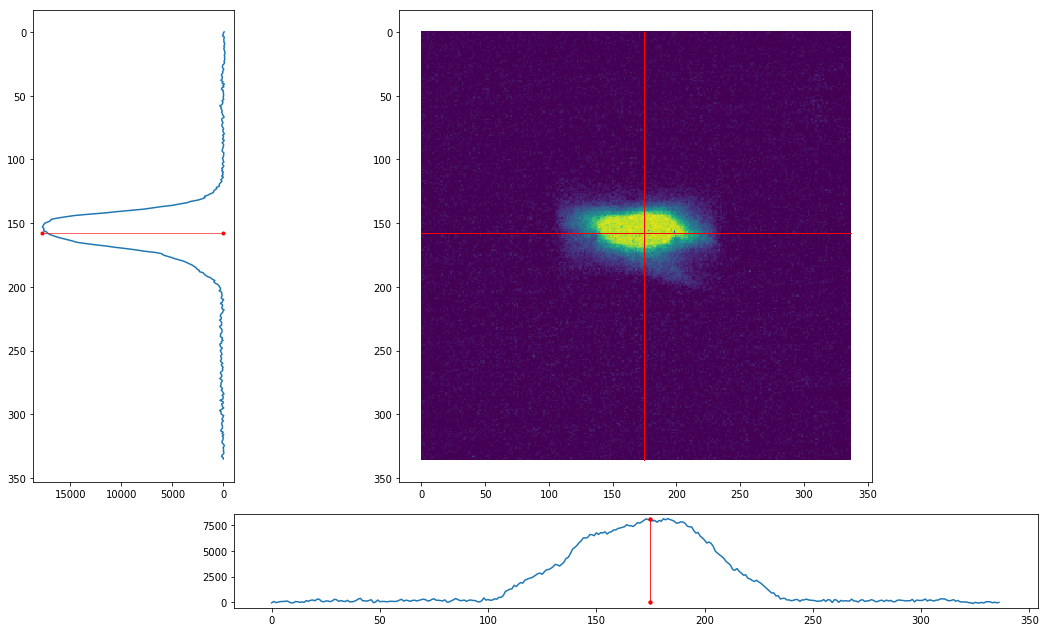

In [8]:
### Image Analysis ###
import datetime
import matplotlib.pyplot as plt 
import scipy.signal as signal
from scipy.signal import savgol_filter

#Reducing selected tune and extracting beam profiles
image=Image(raw_image)
image.subtract_bg(bg)
image.get_profile()
y = np.arange(image.y_size)
x = np.arange(image.x_size)

#Apply a smoothing Savitzky-Golay filter to the arrays: applies a polynomial of order 3 for every 5 data points
y_smooth=savgol_filter(image.profile_y, 5, 3)
x_smooth=savgol_filter(image.profile_x, 5, 3)
median_x=np.median(x_smooth)
median_y=np.median(y_smooth)
std_x=np.std(x_smooth)
std_y=np.std(y_smooth)
mean_x=np.mean(x_smooth)
mean_y=np.mean(y_smooth)
print("median x ", np.where(x_smooth==median_x), " median y ", np.where(y_smooth==median_y)," stdx ", std_x," stdy ",std_y, " mean x", mean_x, "mean y ", mean_y)


#Fit the profiles to selected models and find the point where the median of the data lays
#x_med, x_sigp, x_sign =models[x_profile_model](x_smooth,x)
#y_med, y_sigp, y_sign =models[y_profile_model](y_smooth,y)
#UPDATE 2/12/19:
#instead of fitting with a model, take range that contains of 68% of data without fitting
x_med, x_sigp, x_sign = findMedian(x_smooth)
y_med, y_sigp, y_sign = findMedian(y_smooth)
print(x_med, x_sigp, x_sign , y_med, y_sigp, y_sign )
#### plot and save results ####
fig = plt.figure(figsize=(18, 11))
grid = plt.GridSpec(5, 5, hspace=0.35, wspace=0)
main_ax = fig.add_subplot(grid[:-1, 1:])
#plt.text(210, 5, "Data Median: X=%.1f, Y=%.1f\n Viewer Center: \n Scale: 1 mm is %.1f pixels" %(x_med, y_med, scale/5), size=10,
#         ha="right", va="top",
#         bbox=dict(boxstyle="round",
#                   ec=(0, 0, 0.5),
#                   fc=(1, 1, 1),
#                   )
#        )
#Adding subplots for the profiles
y_hist = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], sharex=main_ax)

#Plot the reduced image in center 
main_ax.imshow(image.subtracted_data)
#main_ax.set_title("Image: "+sys.argv[1]+ "\nScale: %.1f mm is 1 pixel\nData Median: X=%.1f, Y=%.1f, Viewer Center: X=169, Y=164\nCenter X-pos: %.1f mm, Center Y-pos: %.1f mm" %(5/scale, x_med, y_med, abs(x_med-169)*(5/scale), abs(y_med-164)*(5/scale)), fontsize=12)
main_ax.plot([0, image.shape[1]], [y_med,y_med], linewidth=1, color='r')
main_ax.plot( [x_med, x_med], [0, image.shape[0]], linewidth=1, color='r')
#Plotting dots. Their location is relative to to selected region of the light_image
#main_ax.plot(x_min+peaks[:,1], peaks[:,0]+y_min,  'o', markeredgecolor='r', markerfacecolor='none', markersize=5)
#print("Dots are at: \n X:", x_min+peaks[:,1]," Y: ", peaks[:,0]+y_min)
# plot the x and y profiles
x_hist.plot(x, image.profile_x)
x_hist.plot([x_med,x_med],[0, image.profile_x.max()],  linewidth=0.6, color='r', marker='.')
x_hist.plot([x_med,x_med],[0, image.profile_x.max()],  linewidth=0.6, color='r', marker='.')


print("max", image.profile_x.max(), "index", list(image.profile_x).index(image.profile_x.max()) )
#x_hist.plot([x_sigp,x_sigp],[0, image.profile_x.max()],  linewidth=0.6, color='r', linestyle='-')
#x_hist.plot([x_sign,x_sign],[0, image.profile_x.max()],  linewidth=0.6, color='r',  linestyle='-')
#x_hist.set_xlabel("Center X-pos. is at %.1f mm" %(abs(x_med-169)*(5/scale)), fontsize=11)

y_hist.plot(image.profile_y, y)
y_hist.plot([0, image.profile_y.max()], [y_med, y_med], linewidth=0.6, color='r', marker='.')
#y_hist.plot([0, image.profile_y.max()], [y_sign, y_sign], linewidth=0.6, color='r',  linestyle='-')
#y_hist.plot([0, image.profile_y.max()], [y_sigp, y_sigp], linewidth=0.6, color='r',  linestyle='-')
#y_hist.set_title("Center Range between\n%.1f and %.1f pixels" %(y_sign, y_sigp), fontsize=11)
#y_hist.invert_yaxis()

y_hist.invert_xaxis()

#t= pd.to_datetime
timestring = (datetime.datetime.now()).strftime("%m-%d_%H:%M.%f")
#plt.savefig('2_22_ViewerCenter'+'_'+timestring+'.png', dpi=300)

plt.show()

In [7]:
from skimage import  io

#Enter here the images and the methods that will be used for the viewer analysis
#Make sure to inlcude the path to the images

###### Image reduction ########
#Enter here path and name of the tune image
raw_image= io.imread("D1542_images/D1542_2_22_17_34_Q1-2_nom_Q3_half_Q4-5_nom_B1-B2_tuned_050.tiff")
#raw_image= io.imread('tiff_files/Tune115_07722018_viewer_D1542_001.tiff')

#Enter here path and name of the background image (make sure it is the SAME SIZE as the tune image)
bg= io.imread('D1542_images/D1542_2_22_17_34_bg_053.tiff')
#bg= io.imread('/user/secaruser/Documents/viewer_images/vd-d1542/Background_D1542_20190212_final_003.tiff')

###### Finding the real center (dots) of the viewer ######
#Enter here path and name of the image of the viewer with light on. 
#Make sure it is compatible (same size and taken at the same time) with tune!
#light_image= io.imread('tiff_files/180720_D1542_S20_2_003.tiff')
light_image= io.imread('D1542_images/Light_on_D1542_20190211_final_002.tiff')

#Define here middle region of viewer in pixels
#It helps to look at the image first and then refine the region after seeing matches
y_min= 100 #vertical axis in image
y_max= 240
x_min= 90 #horizontal axis in image
x_max= 240

#Enter here path and name of the image of the viewer dots you wish to use as a template
template= io.imread('tiff_files/dots/dot2.tiff') #dot2 seems good

#Enter here the threshold (minimum intensity of peaks) to detect dots on image
#Don't change this at the beginning. It is better to have a good search region first
threshold= 0.04

###### Fitting beam profiles ##########
#Use these as default first then decide after looking at profiles if another model is a better fit
#Options are: single_gaussian, double_gaussian, skewed_gaussian, gaussian_skewed_gaussian
y_profile_model= 'double_gaussian'
x_profile_model= 'skewed_gaussian'